# TASK 2
### There are the results of an A/B test in which two groups of users were offered different sets of promotional offers. It is known that ARPU in the test group is higher by 5% than in the control group. At the same time in the control group 1928 out of 202103 players turned out to be paying, and in the test group 1805 out of 202667 players turned out to be paying. Which set of sentences could be considered the best? What metrics should be analyzed to make the right decision, and how?

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline 


In [2]:
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep=';') 
# Reading data from Yandex Disk

We look at the dataset (data types, missing values, user_id repetitions, whether the data is correct by group ("ARPU in the test group is higher by 5% than in the control group. At the same time, the control group had 1928 players out of 202103 who were paying, and the test group had 1805 out of 202667"))

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [5]:
df.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [6]:
df.user_id.duplicated().sum()

0

In [7]:
df.shape

(404770, 3)

In [8]:
df.query('testgroup == "a"').shape[0]  # Number of players in the control group

202103

In [9]:
df.query('testgroup == "b"').shape[0]  # Number of players in the test group

202667

In [10]:
df.query('testgroup == "a" and revenue >0').shape[0]  # Number of paying players in the control group

1928

In [11]:
df.query('testgroup == "b" and revenue >0').shape[0]  # Number of paying players in the test group

1805

In [12]:
df.groupby('testgroup', as_index=False) \
    .agg({'revenue': 'mean'})  # Calculate ARPU for groups

,testgroup,revenue
0,a,25.413720
1,b,26.751287


In [13]:
round((26.751287 / 25.413720 - 1) * 100, 2)
# Checking the difference in ARPU, we see an increase of 5% as expected from the task description

5.26

The data coincide with those described, we can proceed to the analysis

In [14]:
a = df.query('testgroup == "a" and revenue > 0')
b = df.query('testgroup == "b" and revenue > 0')

Text(0.5, 1.0, 'Revenue distribution for paying users')

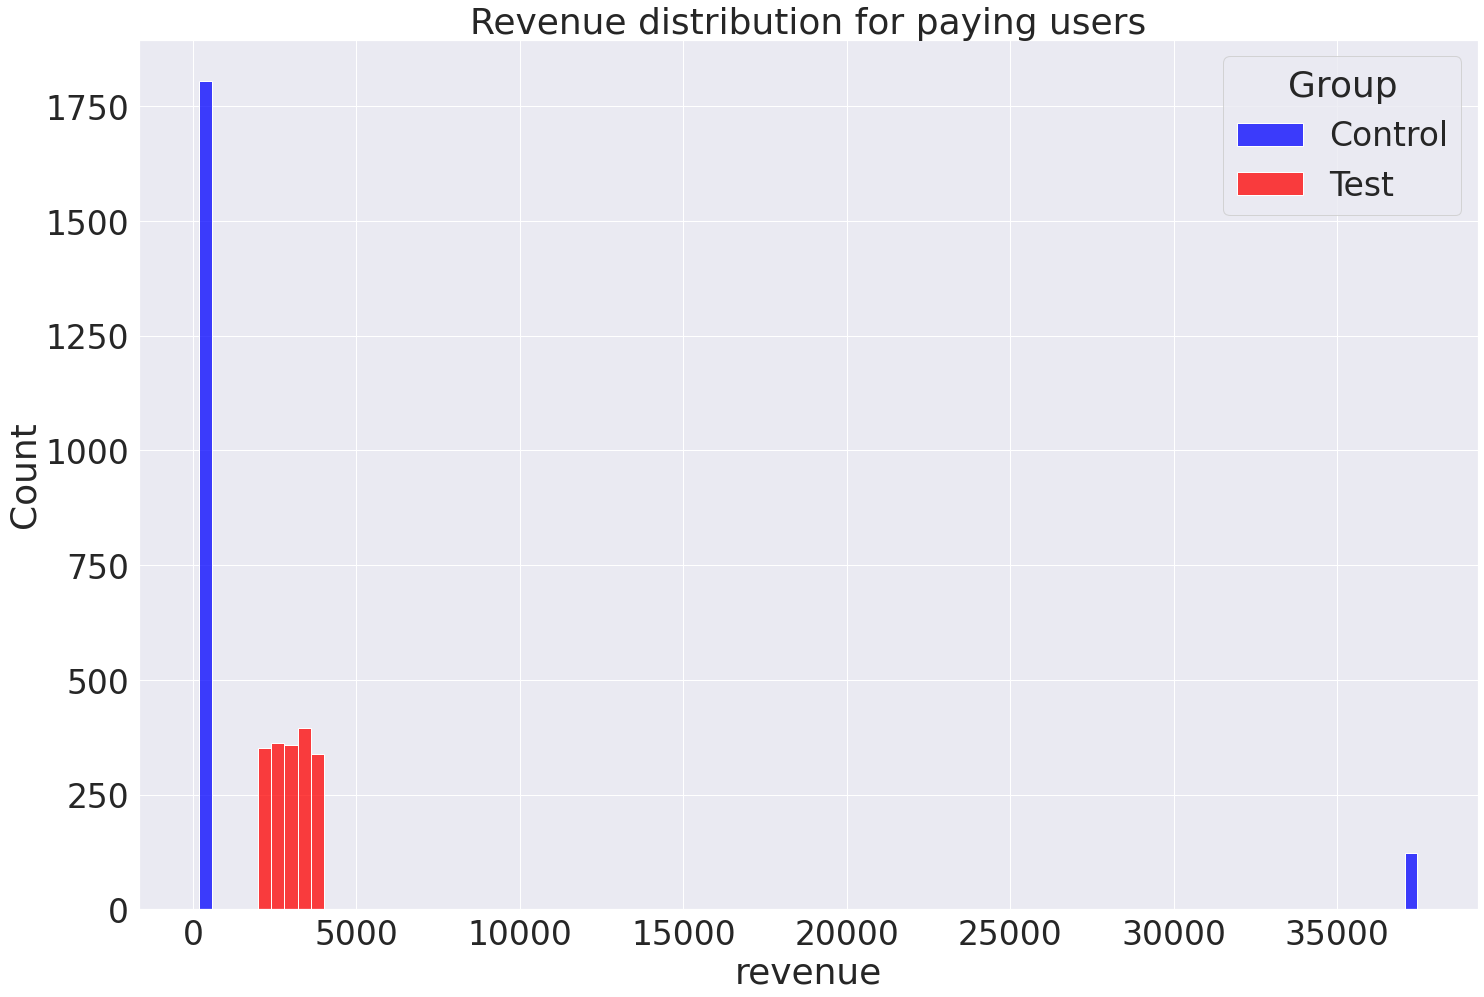

In [15]:
sns.set(rc={'figure.figsize': (24, 16)})
sns.set(font_scale=3)
sns.histplot(data=a, x='revenue', color='blue', bins=100)
sns.histplot(data=b, x='revenue', color='red', bins=5)  # Looking at the distribution of revenue by paying users
plt.legend(title='Group', loc='upper right', labels=['Control', 'Test'])
plt.title('Revenue distribution for paying users')

We see very different behavior between the control group and the test group: the control group has a lot of people paying little more than zero (plankton), and a small number of users paying huge amounts (whales). Whereas in the test group all payers pay significant amounts (dolphins), but an order of magnitude smaller than the whales

We see that the distribution of at least the control group is not normal, so there is no way to compare test and control by t-test. The Mann-Whitney test can help, but if we compare samples of all 200k users, then 99% of the matched values there are zeros. So Mann-Whitney will probably not show us sample differences

In [16]:
scipy.stats.mannwhitneyu(df[df.testgroup == "a"].revenue, df[df.testgroup == "b"].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

pvalue=0.0627, so we cannot reject the null hypothesis of no difference between the samples. This is a fairly expected result for such a sample.
We can perform Mann-Whitney test for samples of paying users, and it will give us a confirmation that these samples are different

In [17]:
scipy.stats.mannwhitneyu(df[df.testgroup == "a"].query('revenue > 0').revenue,
                         df[df.testgroup == "b"].query('revenue > 0').revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

pvalue=0.0, the samples are different (which was already evident to the naked eye, but it is still better to confirm it with numbers). However, we cannot draw any conclusions here, Mann-Whitney is poorly interpreted, and we cannot decide which group is better.
This is where the bootstrap can help us (the function is honestly taken from the lecture on bootstrap)

In [18]:
# Let's declare a function that will allow us to test hypotheses with a bootstrap (quantile)
def get_bootstrap_quantile(
        data_column_1,  # numerical values of the first sample
        data_column_2,  # numerical values of the second sample
        boot_it=1000,  # number of bootstrap subsamples
        qu=0.5,  # which quantile are we looking at
        bootstrap_conf_level=0.95):  # significance level
                           
    """The function takes as input the two series that we are testing, boot_it - the number of subsamples (by default 1000), 
    qu - what quantile we are looking at (default is 0.5), bootstrap_conf_level - significance level (default is 0.95). 
    The output is bootstrap data, confidence interval and p-value"""
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # extracting subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # return parameter
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(np.quantile(a=(samples_1 - samples_2), q=qu))  # - Apply statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
             
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [19]:
# Let's declare a function that will allow us to test hypotheses with a bootstrap (mean value)
def get_bootstrap_mean(
        data_column_1,  # numerical values of the first sample
        data_column_2,  # numerical values of the second sample
        boot_it=1000,  # number of bootstrap subsamples
        bootstrap_conf_level=0.95):  # significance level
           
    """The function takes as input two series, which we test, boot_it - the number of subsamples (by default 1000), 
    bootstrap_conf_level - significance level (default is 0.95). On output 
    outputs bootstrap data, confidence interval and p-value"""
        
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # extracting subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # return parameter
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(np.mean(a=(samples_1 - samples_2)))  # - Apply statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
             
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [20]:
# Let's announce a function that will allow you to visualize the results of the bootstrap
def bootstrap_vis(bootstrap_data):
          
    plt.hist(bootstrap_data["boot_data"], bins=50)
    plt.style.use('ggplot')
    plt.vlines(bootstrap_data["ci"], ymin=0, ymax=200, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')    

Let's bootstrap all users (1000 subsamples, because the process is not very fast)

In [21]:
mean_data_pu = get_bootstrap_mean(df[df.testgroup == "a"].revenue, 
                                  df[df.testgroup == "b"].revenue, 
                                  boot_it=1000)

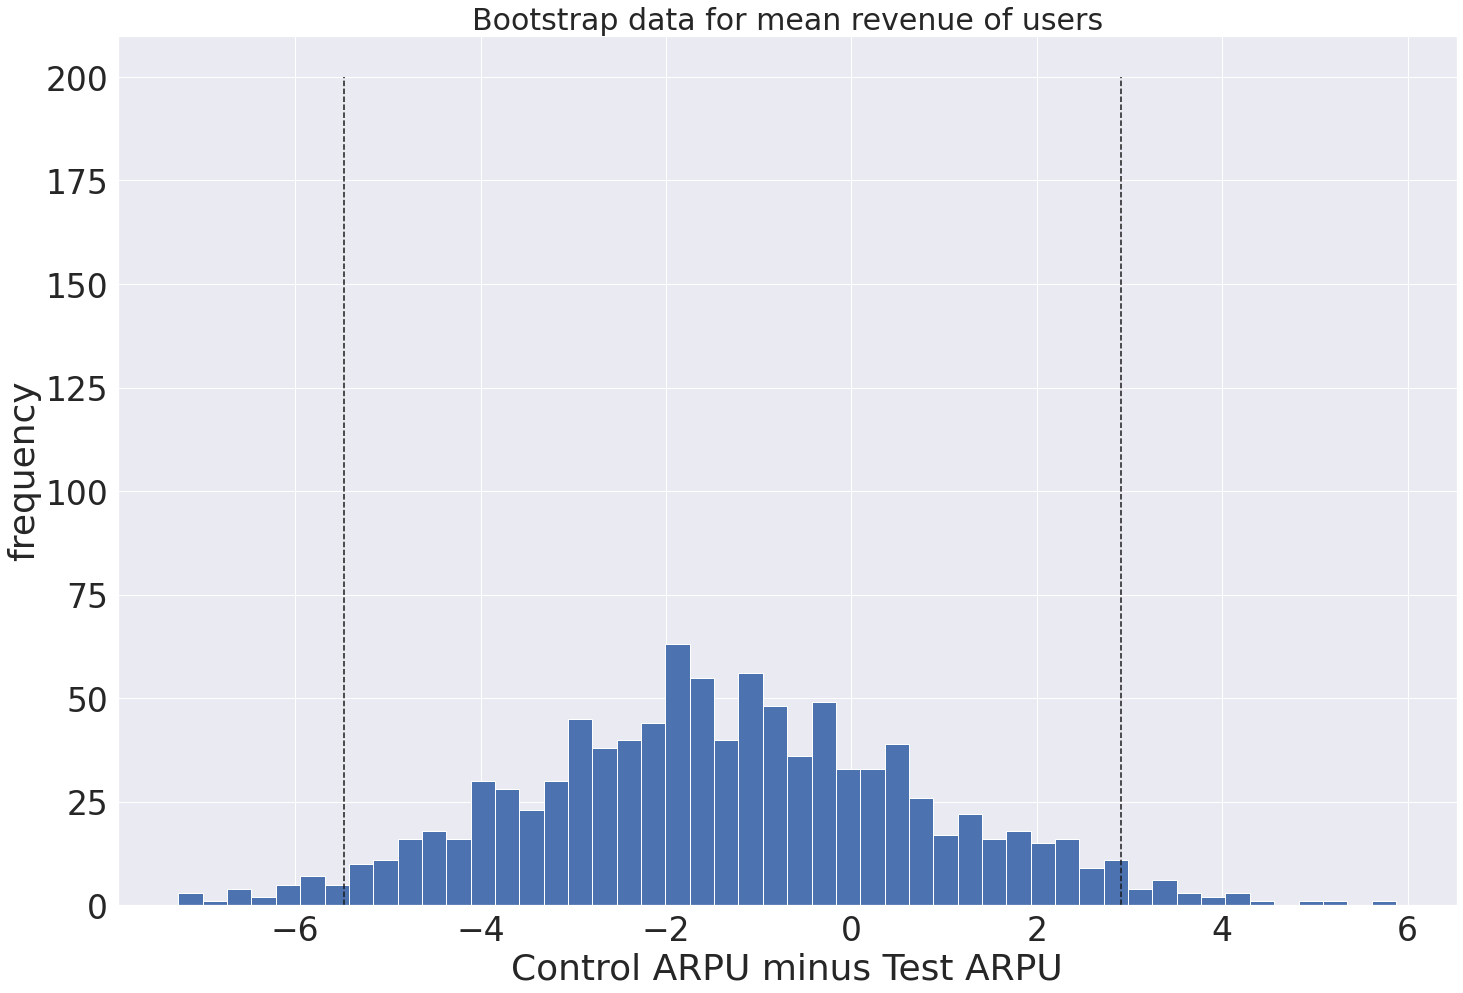

In [22]:
sns.set(font_scale=3)
bootstrap_vis(mean_data_pu)
plt.title("Bootstrap data for mean revenue of users", fontsize=30)
plt.xlabel('Control ARPU minus Test ARPU')
plt.show()

We see that 0 falls within the confidence interval, which means that there is no statistical difference in ARPU

Let's do the same only for paying users

In [23]:
mean_data_ppu = get_bootstrap_mean(df[df.testgroup == "a"].query('revenue > 0').revenue, 
                                   df[df.testgroup == "b"].query('revenue > 0').revenue, 
                                   boot_it=10000)
# We do 10,000 subsamples because we can (there is much less data, the process is fast)

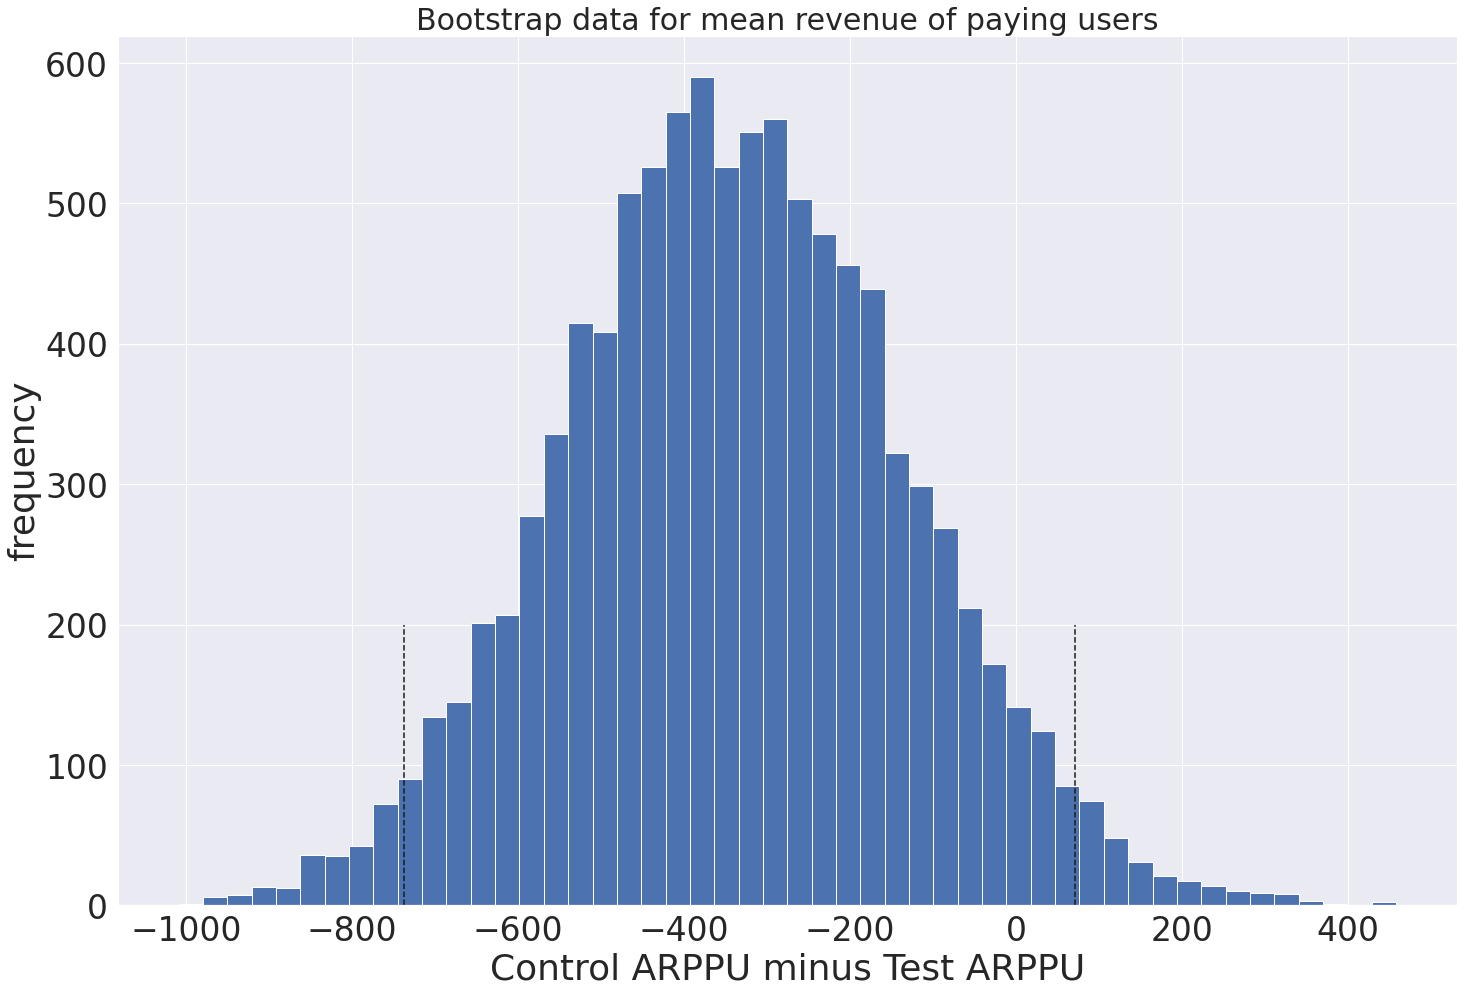

In [24]:
sns.set(font_scale=3)
bootstrap_vis(mean_data_ppu)
plt.title("Bootstrap data for mean revenue of paying users", fontsize=30)
plt.xlabel('Control ARPPU minus Test ARPPU')
plt.show()

0 again falls within the confidence interval, so ARPPU is also not statistically significantly different according to bootstrap data

It turns out that in terms of revenue there is no difference between the sets, both sets showed the same performance. However, let's look at the revenue from 90% of paying users

In [25]:
quantil_data_90_ppu = get_bootstrap_quantile(df[df.testgroup == "a"].query('revenue > 0').revenue, 
                                             df[df.testgroup == "b"].query('revenue > 0').revenue, 
                                             qu=0.90,
                                             boot_it=10000)

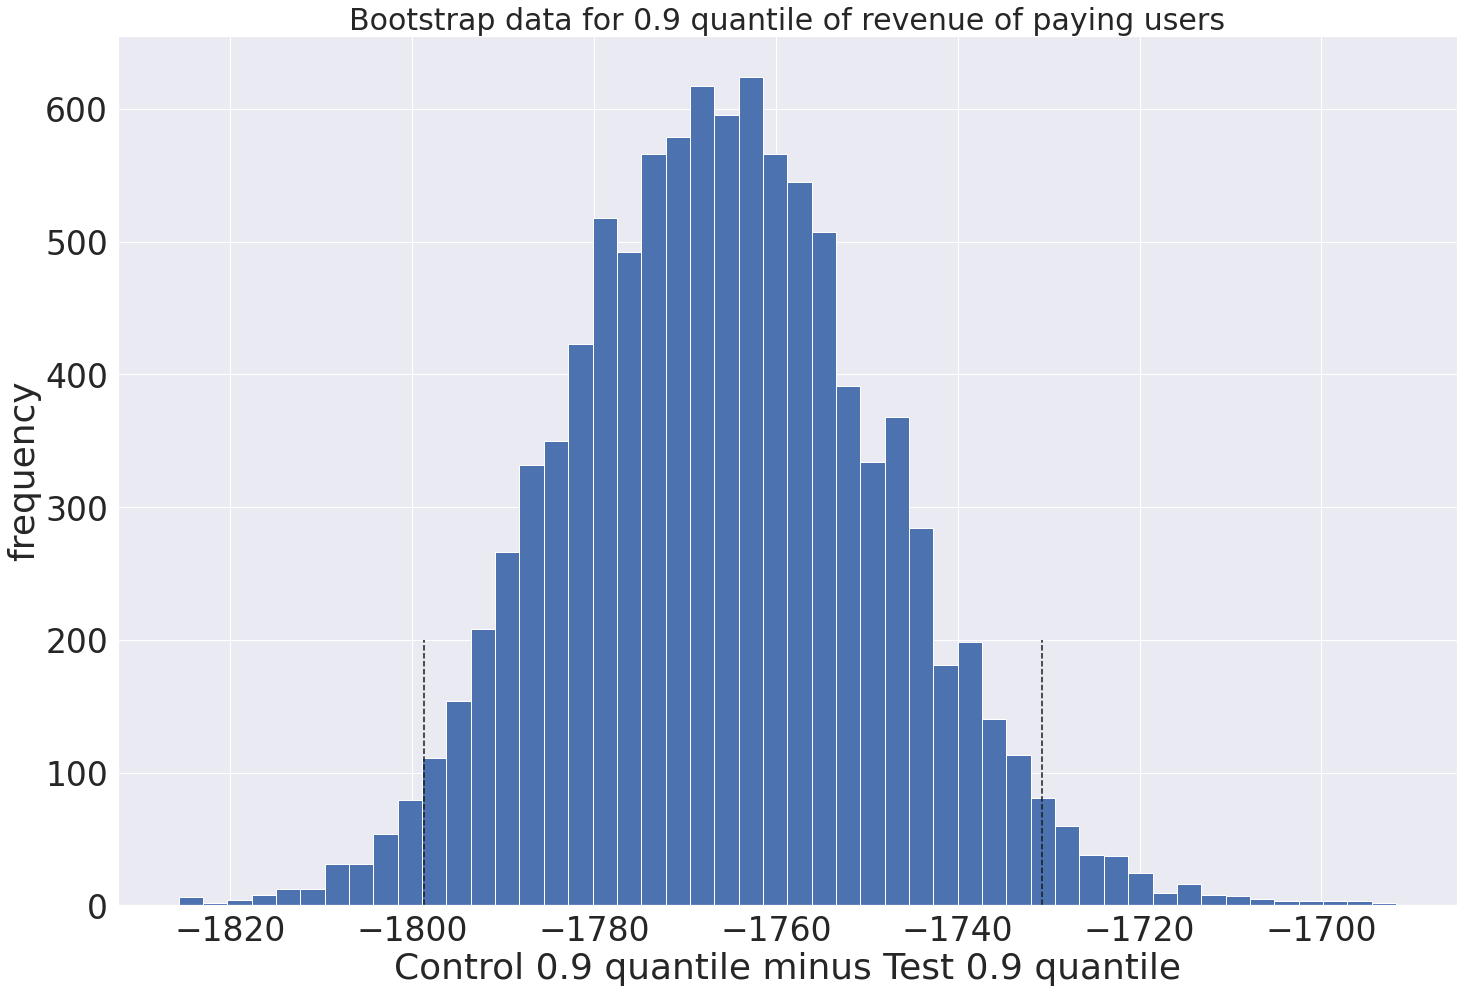

In [26]:
sns.set(font_scale=3)
bootstrap_vis(quantil_data_90_ppu)
plt.title("Bootstrap data for 0.9 quantile of revenue of paying users", fontsize=30)
plt.xlabel('Control 0.9 quantile minus Test 0.9 quantile')
plt.show()

We see that in the control group 90% of users pay markedly less than 90% of users in the test group

In [29]:
round((df[df.testgroup == "a"].query('revenue > 2000') 
       .revenue.sum() / df[df.testgroup == "a"].query('revenue > 0') 
       .revenue.sum()) * 100, 1) 
# Let's calculate the percentage of revenue of whales in the control group 

89.4

In [28]:
df[df.testgroup == "a"].query('revenue > 2000').user_id.count()  # Count the number of whales

123

The last thing you can check is CR with the chi-square, but the result, as I see it, is pretty useless, because we don't know from this data the number of times we see the ad sets, the number of purchases by each user (we only know the total amount) and no such parameters, so it is not quite clear what CR we will get here

#### Conclusion: Both sets have performed similarly in terms of revenue. However, the structure of paying users is very different: In the control group we have a small number of whales (123 people) who provide almost all the revenue (89.4%), while in the test group we have a large number of dolphins (1805 people) who pay from 2000 to 4000.

#### The question for the business is which option is preferable for them: working with a small number of whales, or with a large number of medium-paying dolphins. Based on this, it is worth choosing the final option of sets of offers for players. Personally, I think the test variant with a large number of average paying players is preferable, because there is less dependence on specific players => less risk of losing profits when paying users drop out.
